In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.visualization import plot_spike_counts, raster_plot

# Example cache directory path, it determines where downloaded data will be stored
output_dir = './ecephys_cache_dir/'

manifest_path = os.path.join(output_dir, "manifest.json")

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

pd.set_option('display.max_columns', None)

In [2]:
session_id = 721123822 # 797828357
ecephys_structure_acronyms = 'VISp'

In [3]:
session = cache.get_session_data(session_id)
sel_units = session.units[session.units['ecephys_structure_acronym'] == ecephys_structure_acronyms]

In [4]:
# units center
ccf_coords = ['anterior_posterior_ccf_coordinate', 'dorsal_ventral_ccf_coordinate', 'left_right_ccf_coordinate']
units_coord = sel_units[ccf_coords].values
units_coord_mean = units_coord.mean(axis=0)
center_unit_id = sel_units.index[np.argmin(np.sum((units_coord - units_coord_mean) ** 2, axis=1))]

channel_index = sel_units.loc[center_unit_id, 'probe_channel_number']
probe_id = sel_units.loc[center_unit_id, 'probe_id']

channel_id = session.channels[(session.channels.probe_channel_number == channel_index) & 
                           (session.channels.probe_id == probe_id)].index[0]

In [5]:
fs = session.probes.loc[probe_id].lfp_sampling_rate
stimulus_presentations = session.stimulus_presentations

## Load data

In [6]:
filepath = os.path.join(output_dir, 'session_%d' % session_id,
                        'lfp_probe%d_%s_channel_groups.nc' % (probe_id, ecephys_structure_acronyms))
lfp_array = xr.open_dataset(filepath)
lfp_array = lfp_array.assign_attrs(fs=fs).rename(group_id='channel')
lfp_array

<xarray.Dataset>
Dimensions:  (time: 12263286, channel: 8)
Coordinates:
  * time     (time) float64 0.5328 0.5336 0.5344 ... 9.811e+03 9.811e+03
  * channel  (channel) int32 0 1 2 3 4 5 6 7
Data variables:
    LFP      (channel, time) float32 ...
Attributes:
    fs:       1249.99999145772

In [7]:
channel_group_map = pd.read_csv(filepath.replace('.nc', '.csv'), index_col='id')
group_dv_ccf = dict(zip(channel_group_map['group_id'], channel_group_map['dorsal_ventral_ccf_coordinate']))
group_id = channel_group_map.loc[channel_id, 'group_id']
channel_group_map

,group_id,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate
id,,,,
850245925,7,8545.625000,1435.500000,8019.625000
850245931,7,8545.625000,1435.500000,8019.625000
850245937,7,8545.625000,1435.500000,8019.625000
850245943,6,8575.875000,1347.250000,8024.875000
850245949,6,8575.875000,1347.250000,8024.875000
...,...,...,...,...
850246077,0,8844.181818,583.363636,8054.818182
850246079,0,8844.181818,583.363636,8054.818182
850246081,0,8844.181818,583.363636,8054.818182


In [8]:
stimulus_name = 'drifting_gratings'
filepath = os.path.join(output_dir, 'session_%d' % session_id,
                        'lfp_probe%d_%s_%s_units_pca.csv' % (probe_id, ecephys_structure_acronyms, stimulus_name))
pca_df = pd.read_csv(filepath, index_col='unit_id')

## Analyze spike entrainment to LFP

### Functions

#### Collect LFP data

In [9]:
def align_trials(lfp_array, presentation_ids, onset_times, window=(0., 1.)):
    trial_window = np.arange(window[0], window[1], 1 / lfp_array.fs)
    time_selection = np.concatenate([trial_window + t for t in onset_times])
    inds = pd.MultiIndex.from_product((presentation_ids, trial_window), 
                                      names=('presentation_id', 'time_from_presentation_onset'))
    aligned_lfp = lfp_array.sel(time=time_selection, method='nearest')
    aligned_lfp = aligned_lfp.assign(time=inds).unstack('time')
    return aligned_lfp

def align_gratings(stimulus_presentations, stimulus_name='drifting_gratings'):
    presentations = stimulus_presentations[stimulus_presentations.stimulus_name == stimulus_name]
    null_rows = presentations[presentations['orientation'].values == 'null']
    if len(null_rows):
        null_condition = null_rows.iloc[0]['stimulus_condition_id']
        presentations = presentations[presentations['stimulus_condition_id'] != null_condition]

    presentations_times = presentations['start_time'].values
    presentations_ids = presentations.index.values
    trial_duration = presentations['duration'].max()
    return presentations, presentations_ids, presentations_times, trial_duration

def presentation_conditions(presentations, condtion_types):
    conditions = {c: np.unique(presentations[c]).astype(float) for c in condtion_types}
    cond_id_map = dict(zip(map(tuple, presentations[conditions.keys()].values),
                           presentations['stimulus_condition_id']))
    condition_id = [cond_id_map[x, y] for x, y in zip(*map(np.ravel, np.meshgrid(*conditions.values(), indexing='ij')))]
    condition_id = xr.DataArray(np.reshape(condition_id, tuple(map(len, conditions.values()))), coords=conditions, name='condition_id')
    cond_presentation_id = {c: presentations.index[presentations['stimulus_condition_id'] == c] for c in condition_id.values.ravel()}
    return condition_id, cond_presentation_id

#### Process LFP and spikes. Calculate entrainment.

In [12]:
def bandpass_lfp(aligned_lfp, filt_band, order=4, extend_time=None):
    bfilt, afilt = sp.signal.butter(order, filt_band, btype='bandpass', fs=aligned_lfp.fs)
    axis = aligned_lfp.LFP.dims.index('time_from_presentation_onset')
    filtered = sp.signal.filtfilt(bfilt, afilt, aligned_lfp.LFP, axis=axis)
    analytic = sp.signal.hilbert(filtered)
    filtered_lfp = aligned_lfp.copy()
    filtered_lfp = filtered_lfp.assign(LFP=filtered_lfp.LFP.copy(data=filtered))
    filtered_lfp = filtered_lfp.assign(amplitude=filtered_lfp.LFP.copy(data=np.abs(analytic)))
    filtered_lfp = filtered_lfp.assign(phase=filtered_lfp.LFP.copy(data=np.angle(analytic)))
    if extend_time is None:
        extend_time = aligned_lfp.extend_time
    filtered_lfp = filtered_lfp.assign_attrs(filt_band=filt_band, extend_time=extend_time)
    return filtered_lfp

def get_spike_phase(spike_times, filtered_lfp, unit_channel, time_window=None):
    unit_ids = unit_channel.index
    presentation_ids = filtered_lfp.presentation_id.to_index()
    if time_window is None:
        time_window = (filtered_lfp.time_from_presentation_onset.values[0] + filtered_lfp.extend_time,
                       filtered_lfp.time_from_presentation_onset.values[-1] - filtered_lfp.extend_time)
    spike_trains = [[[] for _ in range(presentation_ids.size)] for _ in range(unit_ids.size)]
    for row in spike_times.itertuples(index=False):
        i = unit_ids.get_loc(row.unit_id)
        j = presentation_ids.get_loc(row.stimulus_presentation_id)
        t = row.time_since_stimulus_presentation_onset
        if t >= time_window[0] and t <= time_window[1]:
            spike_trains[i][j].append(t)
    spike_trains = np.array(spike_trains, dtype=object)

    t0 = filtered_lfp.time_from_presentation_onset.values[0]
    fs = filtered_lfp.fs
    resultant_phase = np.zeros(spike_trains.shape, dtype=complex)
    spike_number = np.zeros(spike_trains.shape, dtype=int)
    for i in range(unit_ids.size):
        unit_phase = filtered_lfp.phase.sel(channel=unit_channel[unit_ids[i]])
        for j in range(presentation_ids.size):
            spike_train = np.array(spike_trains[i, j])
            spike_number[i, j] = spike_train.size
            t = np.round((spike_train - t0) * fs).astype(int)
            phase = unit_phase.isel(presentation_id=j, time_from_presentation_onset=t).values
            resultant_phase[i, j] = np.sum(np.exp(1j * phase))
    spike_phase = xr.Dataset(
        data_vars={
            'spike_number': (['unit_id', 'presentation_id'], spike_number),
            'resultant_phase': (['unit_id', 'presentation_id'], resultant_phase)
        },
        coords={'unit_id': unit_ids, 'presentation_id': presentation_ids},
        attrs={'time_window': time_window}
    )
    return spike_phase

def phase_locking_value(spike_phase, unit_ids=None, presentation_ids=None, unbiased=True):
    if unit_ids is None:
        unit_ids = spike_phase.unit_id
    if presentation_ids is None:
        presentation_ids = spike_phase.presentation_id
    spk_pha = spike_phase.sel(unit_id=unit_ids, presentation_id=presentation_ids).sum(dim='presentation_id')
    pha = spk_pha.resultant_phase.values
    N = spk_pha.spike_number.values
    plv = np.zeros(pha.shape)
    if unbiased:
        plv_ub = np.zeros(pha.shape)
    idx = np.nonzero(N > 1)[0]
    if unbiased:
            plv2 = (pha[idx] * pha[idx].conj()).real / N[idx]
            plv[idx] = (plv2 / N[idx]) ** 0.5
            plv_ub[idx] = (np.fmax(plv2 - 1, 0) / (N[idx] - 1)) ** 0.5
    else:
        plv[idx] = np.abs(pha[idx]) / N[idx]
    mean_firing_rate = N / ((spike_phase.time_window[1] - spike_phase.time_window[0]) * len(presentation_ids))

    ds = xr.Dataset(
        data_vars={
            'PLV': (['unit_id'], plv),
            'phase': (['unit_id'], np.angle(pha, deg=True)),
            'mean_firing_rate': (['unit_id'], mean_firing_rate)
        },
        coords={'unit_id': unit_ids},
        attrs={'angle_unit': 'deg'}
    )
    if unbiased:
        ds = ds.assign({'PLV_unbiased': (['unit_id'], plv_ub)})
    return ds

#### Correlation plots

In [13]:
def correlation_plot(x, y, xlabel=None, ylabel=None, ax=None, **plot_kwargs):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    kwargs = dict(linestyle='none', marker='.')
    kwargs.update(plot_kwargs)
    ax.plot(x, y, **kwargs)
    ax.set_xlabel(x.name if xlabel is None else xlabel)
    ax.set_ylabel(y.name if ylabel is None else ylabel)
    corr = corr_in_plot(x, y, ax)
    return corr

def corr_in_plot(x, y, ax=None, hue=None, **kwargs):
    """Plot the correlation coefficient in the top right hand corner of a plot."""
    corr = sp.stats.pearsonr(x, y).statistic
    ax = ax or plt.gca()
    ax.annotate(f'p={corr:.3f}', xy=(.7, .9), xycoords=ax.transAxes)
    return corr

def aling_axes_limits(axes):
    """Ensure axes match on each pairplot"""
    lims = np.array([[ax.get_xlim() for ax in axes[0, :]], [ax.get_ylim() for ax in axes[:, 0]]])
    lims = np.column_stack([lims[:, :, 0].max(axis=0), lims[:, :, 1].min(axis=0)])
    for i in range(axes.shape[0]):
        for j in range(axes.shape[1]):
            ax = axes[i, j]
            ax.set_xlim(lims[j])
            if i != j:
                ax.set_ylim(lims[i])

def unit_traits(pca_df, plv):
    n_units = len(pca_df)
    _, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.bar(range(n_units), pca_df['projection_on_top_PCs'])
    ax.set_xlim(-1, n_units)
    ax.set_xlabel('units')
    ax.set_ylabel('projection_on_top_PCs, phase_locking_value')
    ax.plot(range(n_units), plv.PLV, color='g', linestyle='none',
            marker='o', markersize=8, markerfacecolor='none', label='PLV')
    ax.plot(range(n_units), plv.PLV_unbiased, color='g', linestyle='none', marker='_', markersize=8, label='unbiased PLV')
    ax.legend(loc='upper center', framealpha=0.2)
    ax2 = ax.twinx()
    ax2.tick_params(axis ='y', labelcolor='r')
    ax2.plot(range(n_units), pca_df['mean_firing_rate'], color='r', linestyle='none',
             marker='o', markersize=8, markerfacecolor='none', label='overall')
    ax2.plot(range(n_units), plv.mean_firing_rate, color='r', linestyle='none',
             marker='_', markersize=8, markerfacecolor='none', label='conditions')
    ax2.set_ylabel('mean_firing_rate', color='r')
    ax2.tick_params(axis ='y', labelcolor='r')
    ax2.legend(loc='upper right', framealpha=0.2)
    plt.show()

### Preprocess

In [14]:
# Get map from unit to channel group id
channels = session.channels.loc[session.channels['structure_acronym'] == ecephys_structure_acronyms]
probe_channel_number_to_id = {row['probe_channel_number']: i for i, row in channels.iterrows()}
unit_channel = pd.Series({i: channel_group_map.loc[probe_channel_number_to_id[u['probe_channel_number']], 'group_id']
                          for i, u in sel_units.iterrows()}, index=sel_units.index, name='channel_group_id')

In [15]:
# Get stimulus trials
extend_time = 0.2
stimulus_name = 'drifting_gratings'
drifting_gratings_presentations, grating_ids, grating_times, grating_duration = align_gratings(
    session.stimulus_presentations, stimulus_name=stimulus_name)
aligned_lfp = align_trials(lfp_array, grating_ids, grating_times, window=(0. - extend_time, grating_duration + extend_time))
aligned_lfp = aligned_lfp.assign_attrs(extend_time=extend_time)

condition_id, cond_presentation_id = presentation_conditions(
    drifting_gratings_presentations, condtion_types=['orientation', 'temporal_frequency'])

# Get spike times
spike_times = session.presentationwise_spike_times(stimulus_presentation_ids=grating_ids, unit_ids=sel_units.index)

### Beta wave

In [29]:
# Get filtered LFP
filt_band = [20., 40.]
lfp_beta = bandpass_lfp(aligned_lfp, filt_band)
spike_phase = get_spike_phase(spike_times, lfp_beta, unit_channel)
print(f'Filter band: (%.1f, %.1f) Hz' % tuple(filt_band))

Filter band: (20.0, 40.0) Hz


#### Calculate entrainment

In [17]:
sel_tfreq = condition_id.temporal_frequency[:3]
sel_cond = condition_id.sel(temporal_frequency=sel_tfreq)
sel_present = np.concatenate([cond_presentation_id[c] for c in np.ravel(sel_cond)])
plv = phase_locking_value(spike_phase, presentation_ids=sel_present, unbiased=True)

print('Selected conditions:')
print(sel_cond.orientation.to_series().to_string(index=False))
print(sel_cond.temporal_frequency.to_series().to_string(index=False))

Selected conditions:
orientation
  0.0
 45.0
 90.0
135.0
180.0
225.0
270.0
315.0
temporal_frequency
1.0
2.0
4.0


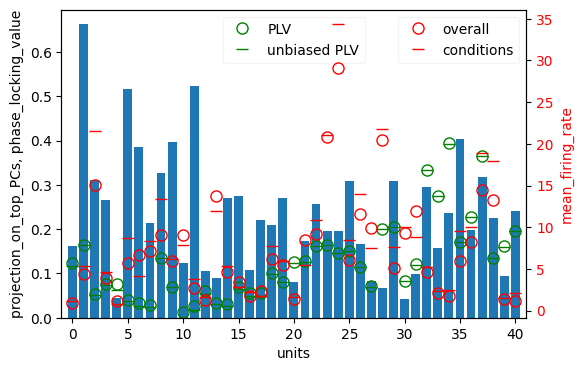

In [18]:
unit_traits(pca_df, plv)

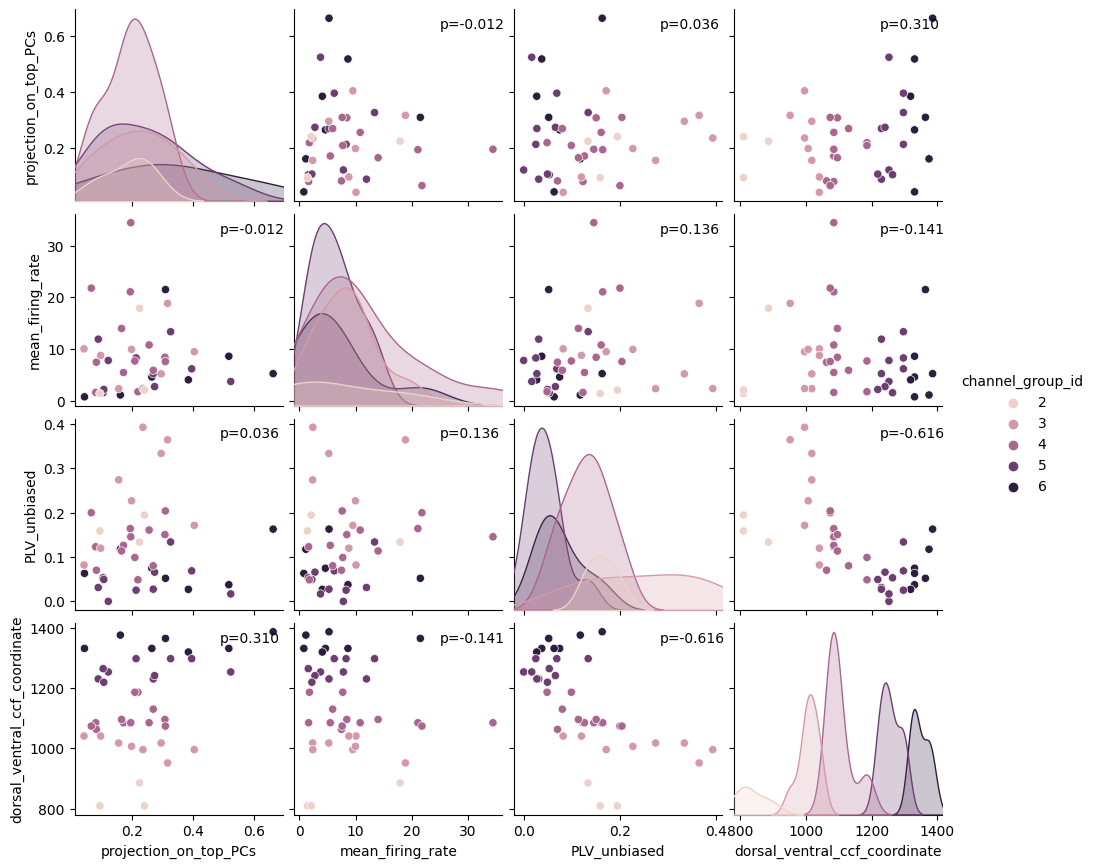

In [19]:
unit_properties = pd.DataFrame({df.name: df for df in [
    pca_df['projection_on_top_PCs'],
    plv.mean_firing_rate.to_series(),
    plv.PLV_unbiased.to_series(),
    sel_units['dorsal_ventral_ccf_coordinate'],
    unit_channel
]}, index=sel_units.index)

g = sns.pairplot(unit_properties, hue='channel_group_id', diag_kind='kde', height=2.2, aspect=1.1)
g.map_offdiag(corr_in_plot)
aling_axes_limits(g.axes)
plt.show()

In [20]:
sel_orient = condition_id.orientation.sel(orientation=[45, 90, 225, 270])
sel_cond = condition_id.sel(temporal_frequency=sel_tfreq, orientation=sel_orient)
sel_present = np.concatenate([cond_presentation_id[c] for c in np.ravel(sel_cond)])
plv_orient = phase_locking_value(spike_phase, presentation_ids=sel_present, unbiased=True)

print('Selected conditions:')
print(sel_cond.orientation.to_series().to_string(index=False))
print(sel_cond.temporal_frequency.to_series().to_string(index=False))

Selected conditions:
orientation
 45.0
 90.0
225.0
270.0
temporal_frequency
1.0
2.0
4.0


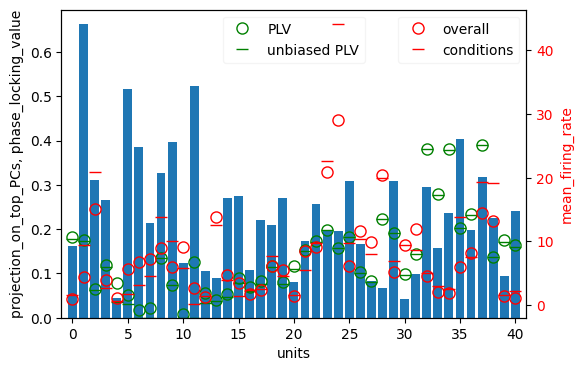

In [21]:
unit_traits(pca_df, plv_orient)

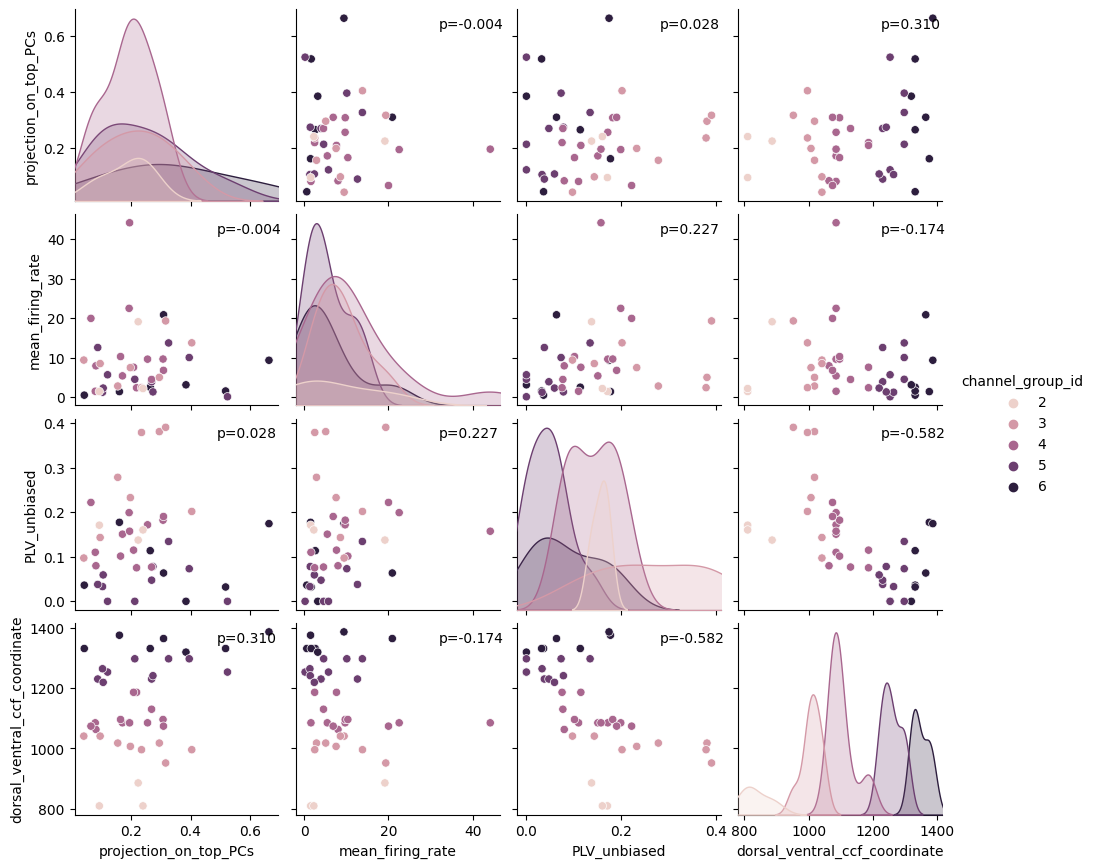

In [22]:
unit_properties = pd.DataFrame({df.name: df for df in [
    pca_df['projection_on_top_PCs'],
    plv_orient.mean_firing_rate.to_series(),
    plv_orient.PLV_unbiased.to_series(),
    sel_units['dorsal_ventral_ccf_coordinate'],
    unit_channel
]}, index=sel_units.index)

g = sns.pairplot(unit_properties, hue='channel_group_id', diag_kind='kde', height=2.2, aspect=1.1)
g.map_offdiag(corr_in_plot)
aling_axes_limits(g.axes)
plt.show()

Change in mean_firing_rate and PLV_unbiased after selecting preferred orientations.


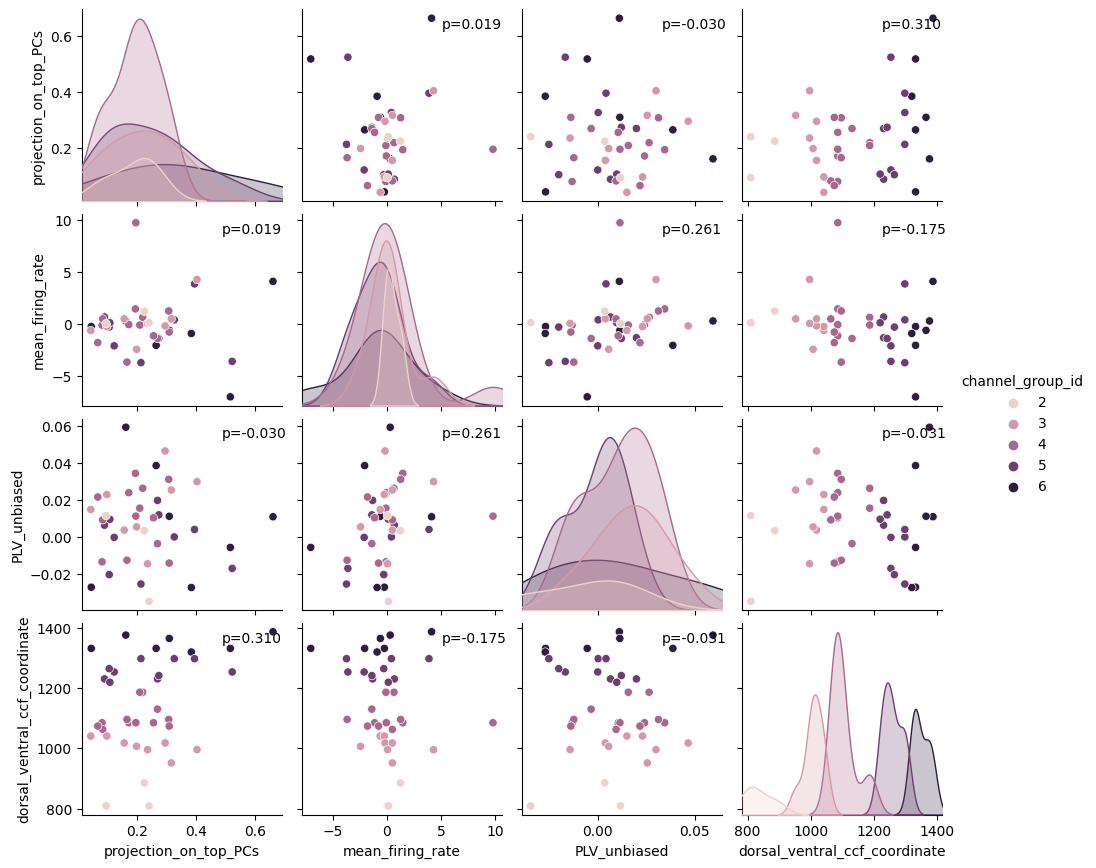

In [23]:
unit_properties = pd.DataFrame({df.name: df for df in [
    pca_df['projection_on_top_PCs'],
    (plv_orient.mean_firing_rate - plv.mean_firing_rate).to_series(),
    (plv_orient.PLV_unbiased - plv.PLV_unbiased).to_series(),
    sel_units['dorsal_ventral_ccf_coordinate'],
    unit_channel
]}, index=sel_units.index)

g = sns.pairplot(unit_properties, hue='channel_group_id', diag_kind='kde', height=2.2, aspect=1.1)
g.map_offdiag(corr_in_plot)
aling_axes_limits(g.axes)

print('Change in mean_firing_rate and PLV_unbiased after selecting preferred orientations.')
plt.show()

### Gamma wave

In [31]:
# Get filtered LFP
filt_band = [40., 75.]
duration = [0., 1.]
lfp_gamma = bandpass_lfp(aligned_lfp.sel(time_from_presentation_onset=slice(duration[0] - extend_time, duration[1] + extend_time)),
                         filt_band, extend_time=extend_time)
spike_phase = get_spike_phase(spike_times, lfp_gamma, unit_channel)
print(f'Filter band: (%.1f, %.1f) Hz' % tuple(filt_band))
print(f'Duration: (%.3f, %.3f) sec' % tuple(duration))

Filter band: (40.0, 75.0) Hz
Duration: (0.000, 1.000) sec


### Calculate entrainment

In [25]:
sel_tfreq = condition_id.temporal_frequency[:3]
sel_cond = condition_id.sel(temporal_frequency=sel_tfreq)
sel_present = np.concatenate([cond_presentation_id[c] for c in np.ravel(sel_cond)])
plv_gamma = phase_locking_value(spike_phase, presentation_ids=sel_present, unbiased=True)

print('Selected conditions:')
print(sel_cond.orientation.to_series().to_string(index=False))
print(sel_cond.temporal_frequency.to_series().to_string(index=False))

Selected conditions:
orientation
  0.0
 45.0
 90.0
135.0
180.0
225.0
270.0
315.0
temporal_frequency
1.0
2.0
4.0


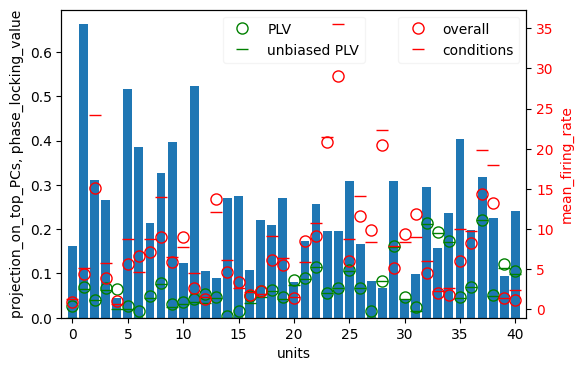

In [26]:
unit_traits(pca_df, plv_gamma)

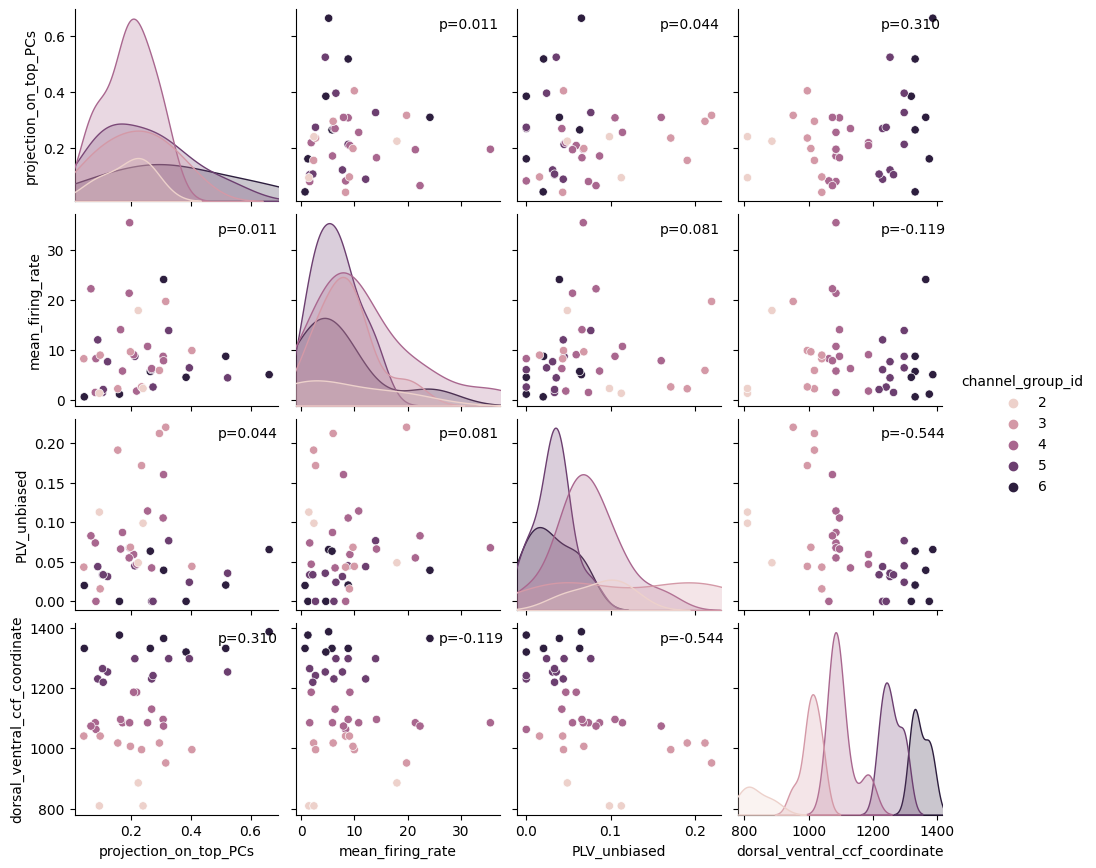

In [27]:
unit_properties = pd.DataFrame({df.name: df for df in [
    pca_df['projection_on_top_PCs'],
    plv_gamma.mean_firing_rate.to_series(),
    plv_gamma.PLV_unbiased.to_series(),
    sel_units['dorsal_ventral_ccf_coordinate'],
    unit_channel
]}, index=sel_units.index)

g = sns.pairplot(unit_properties, hue='channel_group_id', diag_kind='kde', height=2.2, aspect=1.1)
g.map_offdiag(corr_in_plot)
aling_axes_limits(g.axes)
plt.show()